# TKT4108 Structural dynamics 2

## Solution exercise 10

**Main topics:**  Estimation of spectra

**References:** Github examples, lecture notes



### Problem 1

**a)**

The auto spectral density of the response is defined by

$$S_y(\omega) = |H(\omega) |^2 S_x(\omega)$$

The standard deviation is the square root of the auto spectral density integral:

$$ \sigma_y = \sqrt{ \int_{-\infty}^{\infty}{S_y(\omega)} d\omega } $$

(0.0, 20.0)

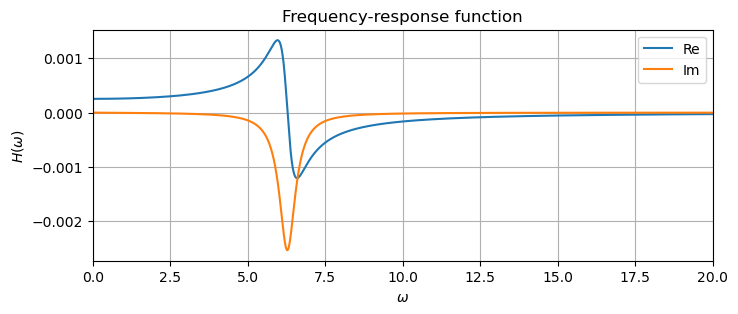

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as spsi

import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

fn = 1
xi = 5/100
omegan = 2*np.pi*fn
ms = 100
ks = omegan**2*ms

cs = 2*xi*ms*omegan

omega_axis = np.linspace(0,50,10001)

H = 1/(-omega_axis**2*ms + 1j*omega_axis*cs + ks) # Frequency response function

plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.real(H),label='Re')
plt.plot(omega_axis,np.imag(H),label='Im')
plt.xlabel('$\omega$')
plt.ylabel('$H(\omega)$')
plt.title('Frequency-response function')
plt.grid()
plt.legend()
plt.xlim(0,20)

(0.0, 40.0)

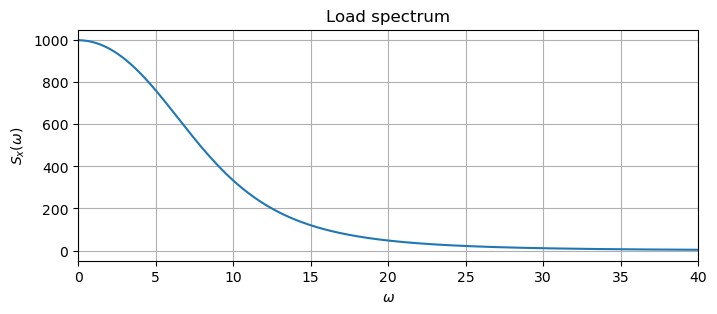

In [16]:
Sx = 1e3/(1+0.01*omega_axis**2+0.0001*omega_axis**4)

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sx)
plt.xlabel('$\omega$')
plt.ylabel('$S_x(\omega)$')
plt.grid()
plt.title('Load spectrum')
plt.xlim(0,40)

The standard deviation is 0.0647 m


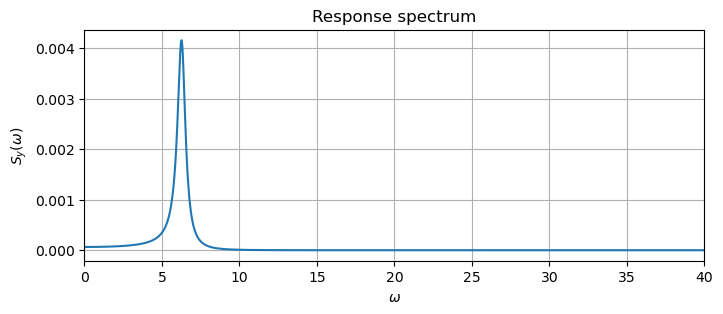

In [17]:
Sy = np.abs(H)**2*Sx

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sy)
plt.xlabel('$\omega$')
plt.ylabel('$S_y(\omega)$')
plt.grid()
plt.title('Response spectrum')
plt.xlim(0,40)

sigma_y=np.trapz(Sy,omega_axis)**0.5

print('The standard deviation is ' + '{:.4f}'.format(sigma_y) + ' m')

**b)**

We can obtain realizations of the load based on its auto-spectral density by Monte Carlo simulation. We use the formulation based on the fast Fourier transform since this is the most effective approach.

$$x(t) = \Re \left(IFFT \left( A_k e^{i \phi_k} \right) \right)$$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$.

domega is 0.006283185307179587


(0.0, 1000.0)

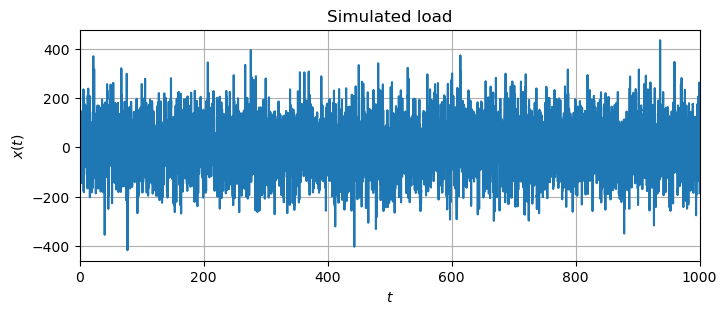

In [18]:

dt=0.02

T=1000

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))

omega_sim = np.arange(0,N,1)*domega # Frequency axis

Sx = 1e3/(1+0.01*omega_sim**2+0.0001*omega_sim**4)

# Generate load
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c)*N) # The IFFT

plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.grid()
plt.title('Simulated load')
plt.xlim(0,T)



Response by Newmark's method

(0.0, 1000.0)

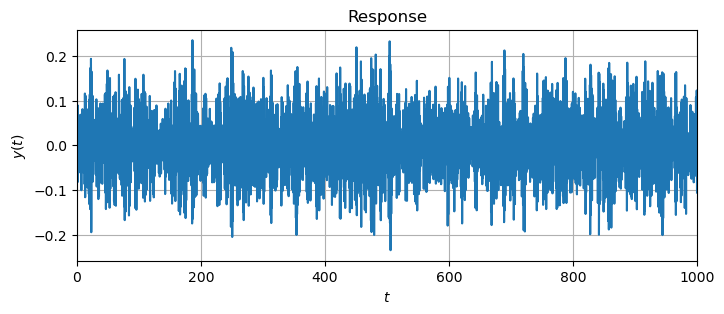

In [19]:
u0 = 0.0
udot0 = 0.0

y, _,_ = linear_newmark_krenk(ms,cs,ks,x,u0,udot0,dt)

plt.figure(figsize=(8,3))
plt.plot(t,y[0,:])
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.grid()
plt.title('Response')
plt.xlim(0,T)


To asses how long time series is need to estimate the standard deviation, we can calculate the standard deviation as function of the length of the time series.

Text(0.5, 0, 't')

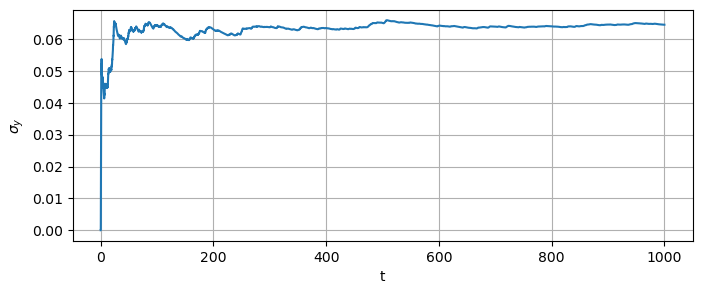

In [20]:
sd_time = np.zeros(t.shape[0])
for k in range(1,t.shape[0]):
    sd_time[k] = np.std(y[0,0:k])
    
plt.figure(figsize=(8,3))
plt.plot(t,sd_time)
plt.grid()
plt.ylabel('$\sigma_y$')
plt.xlabel('t')

The plot above illustrates that we get a pretty good estimate of the standard deviation considering a time series of 400 seconds duration. This depends on the particular realization of the loading and it is important to perform a check whether the estimated statistical properties have converged. In general, the duration will also depend on the natural frequencies in the response. In this example the frequency was 1 Hz, so approximately 400 cycles were needed.

**c**)


The auto-spectral density can be estimated as follows:

 $$ S_{x}(f_k)  = \lim_{T\rightarrow \infty} \text{E} [ \: T \cdot X_k \bar{X}_k \: ]  $$

$X_k$ is the discrete Fourier transform, which is two-sided (goes from $-f_s/2$ to $f_s/2$). To get a one-sided spectrum, we must multiply by 2.

In addition, $S_{x}(f_k)$ is a spectrum as a function of $f$ (Hz). To get $S_{x}(\omega)$, we must scale by $2 \pi$:

$$ S_{x}(\omega)=S_{x}(f) /(2 \pi) $$



domega is 0.010471975511965976
0.004308999666405247


(0.0, 20.0)

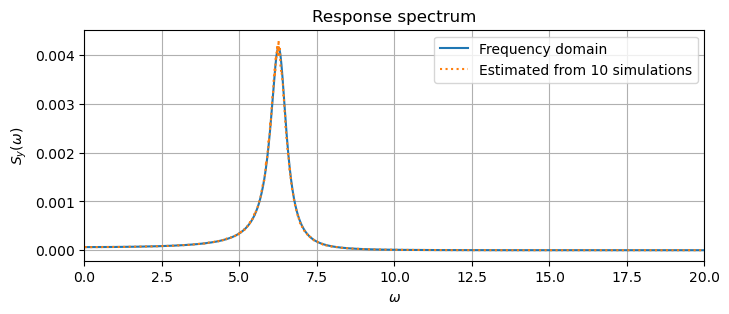

In [22]:

dt=0.02
T=600
N=int(T/dt)
    
t=np.arange(0,N,1)*dt # Time axis
    
domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))
    
omega_sim = np.arange(0,N,1)*domega # Frequency axis

Sx = 1e3/(1+0.01*omega_sim**2+0.0001*omega_sim**4)

Nsim = 10
Sy_est_twosided_mean = np.zeros(len(t))

for k in range(Nsim):
    
    # Generate load
    phi = np.random.rand(N)*2*np.pi # Random phase angles 
    c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
    x = np.real(np.fft.ifft(c)*N) # The IFFT

    u0 = 0.0
    udot0 = 0.0
    
    y, _,_ = linear_newmark_krenk(ms,cs,ks,x,u0,udot0,dt)

    Y_fft = np.fft.fft(y)/N
    Y_fft = np.fft.fftshift(Y_fft) # Shift elements in vector, goes from [-omega,...,0,...+omega]

    f_fft = np.fft.fftfreq(N, d=dt) # Frequency axis in Hz
    f_fft_shift = np.fft.fftshift(f_fft)

    Sy_est_twosided=T*np.real(np.multiply(Y_fft,np.conj(Y_fft))) # Estimate spectrum (two-sided and function of Hz)
    
    Sy_est_twosided_mean = Sy_est_twosided_mean + Sy_est_twosided

Sy_est_twosided_mean = Sy_est_twosided_mean/Nsim

omega_est=f_fft_shift[f_fft_shift>0]*2*np.pi
Sy_est_mean=Sy_est_twosided_mean[0,f_fft_shift>0]/(2*np.pi)*2

print(np.max(Sy_est_mean))
    
# Plot and compare with exact solution
plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sy ,label = 'Frequency domain',color='C0') 
plt.plot(omega_est,Sy_est_mean,':' ,label = 'Estimated from ' + str(Nsim) +' simulations' ,color='C1') 
plt.xlabel('$\omega$')
plt.ylabel('$S_y(\omega)$')
plt.grid()
plt.title('Response spectrum')
plt.legend()
plt.xlim(0,20)


We see that the two graphs are similar (as they should be). The estimate still has some slight noise and will fully converge as the time series becomes longer ($T\rightarrow \infty$) and the number of averages is increased ($N\rightarrow \infty$).

### Problem 2

**a**)

In [35]:
import numpy as np
from scipy import linalg as spla

M = np.eye(5) *1000
K = np.zeros((6,6))
EI = 2.1e11*3.34e-6
L = 3
ks = 2 *12*EI/L**3

for k in range(5):
    K[k+1,k+1] = K[k+1,k+1] + ks
    K[k,k] = K[k,k] + ks
    K[k+1,k] = K[k+1,k] -ks
    K[k,k+1] = K[k,k+1] -ks

K = K[1::,1::] # Introduce boundary conditions

lam, vec = spla.eig(K,M)

indx = np.argsort(lam)
lam = lam[indx]

vec = vec[:,indx]

f = np.real(lam**0.5)/2/np.pi

M_modal = vec.T @ M @ vec

C_modal = 2*np.eye(5)*5/100*M_modal*np.diag(f)*2*np.pi

C = vec @ C_modal @ vec.T

# Verify that the target damping has been achieved by re-calculation of damping

# State-space A-matrix
A = np.block([
    [np.zeros_like(M), np.eye(M.shape[0])],
    [-np.linalg.inv(M) @ K, -np.linalg.inv(M) @ C]
])

# State-space B-matrix
B = np.block([
    [np.zeros_like(M)],
    [np.linalg.inv(M)]
])

lam,vec = np.linalg.eig(A)
f = np.abs(lam)/2/np.pi
xi = -np.real(lam)/np.abs(lam)

print('Calculated damping ratios: ')
print(xi)

print('Calculated natural frequencies: ')
print(f)

Calculated damping ratios: 
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
Calculated natural frequencies: 
[7.62603064 7.62603064 6.68626597 6.68626597 5.20481979 5.20481979
 3.30171007 3.30171007 1.13111544 1.13111544]


**b**)

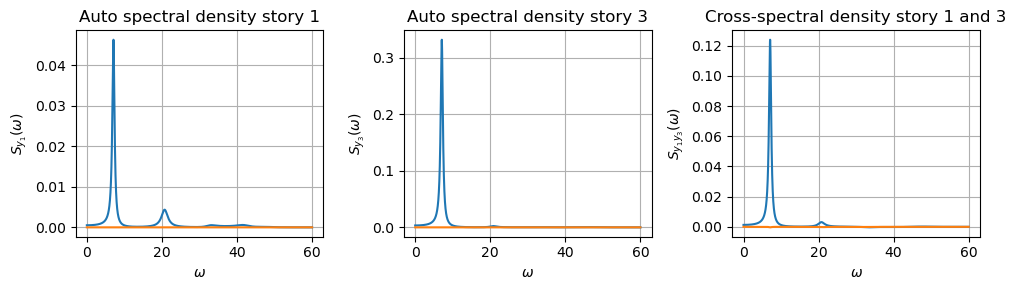

In [25]:
omega_axis = np.linspace(0,60,10000)
H = np.zeros((M.shape[0],M.shape[0],len(omega_axis)),dtype = complex)
Sx = np.zeros((M.shape[0],M.shape[0],len(omega_axis)))
Sy = np.zeros((M.shape[0],M.shape[0],len(omega_axis)),dtype = complex)

Sx[1,1,omega_axis<60] = 1e8
Sx[3,3,omega_axis<60] = 1e8

for k in range(len(omega_axis)):
    H[:,:,k] = np.linalg.inv(-omega_axis[k]**2*M + 1j*omega_axis[k]*C + K)
    Sy[:,:,k] = np.conj(H[:,:,k]) @ Sx[:,:,k] @ H[:,:,k].T
    
fig, axs = plt.subplots(1,3,figsize=(10,3))

axs[0].plot(omega_axis,np.real(Sy[0,0,:]))
axs[0].plot(omega_axis,np.imag(Sy[0,0,:]))
axs[0].set_xlabel("$\omega$")
axs[0].set_ylabel("$S_{y_1}(\omega$)")
axs[0].set_title("Auto spectral density story 1")
axs[0].grid()

axs[1].plot(omega_axis,np.real(Sy[2,2,:]))
axs[1].plot(omega_axis,np.imag(Sy[2,2,:]))
axs[1].set_xlabel("$\omega$")
axs[1].set_ylabel("$S_{y_3}(\omega$)")
axs[1].set_title("Auto spectral density story 3")
axs[1].grid()

axs[2].plot(omega_axis,np.real(Sy[0,2,:]))
axs[2].plot(omega_axis,np.imag(Sy[0,2,:]))
axs[2].set_ylabel("$S_{y_1 y_3}(\omega$)")
axs[2].set_xlabel("$\omega$")
axs[2].set_title("Cross-spectral density story 1 and 3")
axs[2].grid()

plt.tight_layout()


**c)**

domega is 0.003490658503988659


Text(0.5, 1.0, 'Response')

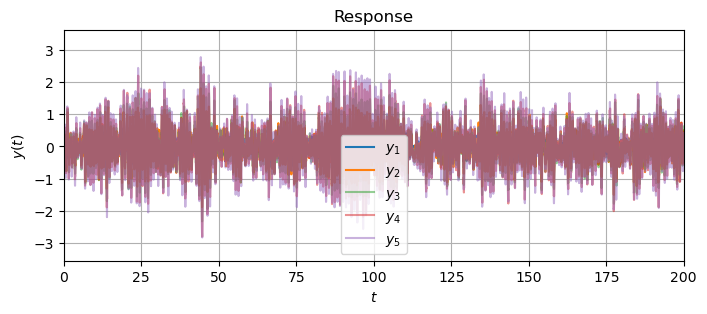

In [66]:
import scipy

dt=0.01

T=1800

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))

omega_sim = np.arange(0,N,1)*domega # Frequency axis

Sx_sim=np.zeros_like(omega_sim)
Sx_sim[omega_sim<60] = 1e8

# Generate load x2
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Sx_sim*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x2 = np.real(np.fft.ifft(c)*N) # The IFFT

# Generate load x4
phi = np.random.rand(N)*2*np.pi # Random phase angles 
c = (2*Sx_sim*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x4 = np.real(np.fft.ifft(c)*N) # The IFFT

x=np.zeros((5,len(t)))
x[1,:]=x2
x[3,:]=x4

# Convert state-space matrix to discrete time
A_d = scipy.linalg.expm(A * dt)
B_d = np.dot( scipy.linalg.expm(A * dt) - np.eye(A.shape[0]), np.linalg.inv(A)) @ B

x_state=np.zeros((10,len(t))) # State vector

# Discrete time forward model
for k in np.arange(len(t)-1):

    x_state[:, k+1] = A_d @ x_state[:, k] +  B_d @  x[:, k]

y=x_state[0:5,:]

# Plot DOF 1-3
plt.figure(figsize=(8,3))
plt.plot(t,y[0,:],label='$y_1$')
plt.plot(t,y[1,:],label='$y_2$')
plt.plot(t,y[2,:],label='$y_3$',alpha=0.5)
plt.plot(t,y[3,:],label='$y_4$',alpha=0.5)
plt.plot(t,y[4,:],label='$y_5$',alpha=0.5)
plt.ylabel('$y(t)$')
plt.xlabel('$t$')
plt.xlim(0,200)
plt.legend()
plt.grid()
plt.title('Response')



**d**)

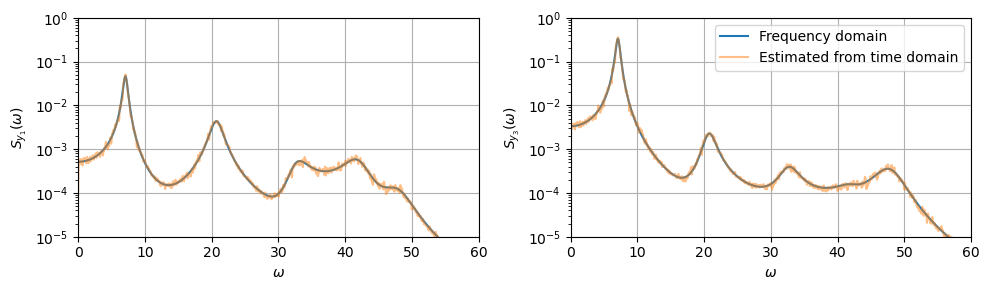

In [65]:
ndivisions = 20 # Number of divisions of the time series (total segments)
nwindow = np.ceil(len(t)/ndivisions) # Length of window/segment
noverlap = np.ceil(nwindow/2)

nfft_pow2 = 2**(np.ceil(np.log2(nwindow))) # Next power of 2 for zero padding

# Call welch from scipy signal processing
f_welch, Sy_1_tmp = spsi.welch(y[0,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

omega_welch = f_welch*2*np.pi # Transform to rad/s
Sy_1 = Sy_1_tmp/(2*np.pi) # Transform to rad/s

# Call welch from scipy signal processing
_, Sy_3_tmp = spsi.welch(y[2,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
Sy_3 = Sy_3_tmp/(2*np.pi) # Transform to rad/s

fig, axs = plt.subplots(1,2,figsize=(10,3))

axs[0].plot(omega_axis,np.real(Sy[0,0]),label='Frequency domain')
axs[0].plot(omega_welch,Sy_1,label = 'Estimated from time domain',alpha=0.5)
axs[0].set_xlim(0,60)
axs[0].grid()
axs[0].set_yscale('log')
axs[0].set_ylim(1e-5,1e0)
axs[0].set_xlabel('$\omega$')
axs[0].set_ylabel('$S_{y_1}(\omega)$')

axs[1].plot(omega_axis,np.real(Sy[2,2]),label='Frequency domain')
axs[1].plot(omega_welch,Sy_3,label = 'Estimated from time domain',alpha=0.5)
axs[1].set_xlim(0,60)
axs[1].grid()
axs[1].set_yscale('log')
axs[1].set_ylim(1e-5,1e0)
axs[1].set_xlabel('$\omega$')
axs[1].set_ylabel('$S_{y_3}(\omega)$')

axs[1].legend()

plt.tight_layout()

Anything between 5 and 25 divisions seems to give decent estimates. The higher side (approx. 20) gives good results since the time series is very long (30 minutes), so the length of each division still is relatively long. A much short time series could not have been divided into so many divisions with good results.

**e**)

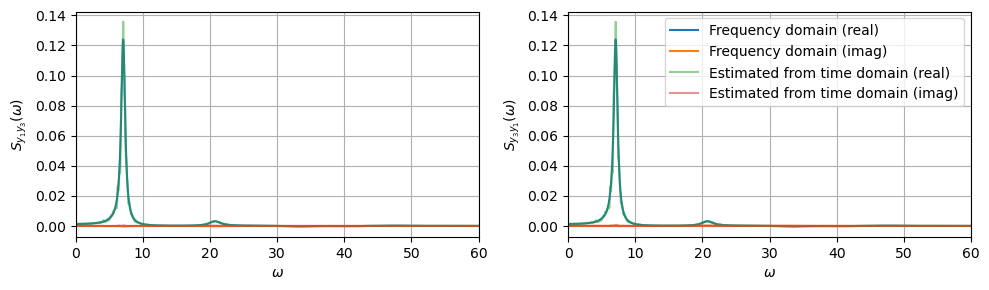

In [63]:
# Call welch from scipy signal processing
f, Sy_13_tmp = spsi.csd(y[0,:], y[2,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
f, Sy_31_tmp = spsi.csd(y[2,:], y[0,:], fs=1/dt, window='hann', nperseg=nwindow, noverlap=noverlap, nfft=nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

Sy_13 = Sy_13_tmp/(2*np.pi) # Transform to rad/s
Sy_31 = Sy_31_tmp/(2*np.pi) # Transform to rad/s


fig, axs = plt.subplots(1,2,figsize=(10,3))

axs[0].plot(omega_axis,np.real(Sy[0,2]),label='Frequency domain (real)')
axs[0].plot(omega_axis,np.imag(Sy[0,2]),label='Frequency domain (imag)')
axs[0].plot(omega_welch,np.real(Sy_13),label = 'Estimated from time domain (real)',alpha=0.5)
axs[0].plot(omega_welch,np.imag(Sy_31),label = 'Estimated from time domain (imag)',alpha=0.5)
axs[0].set_xlim(0,60)
axs[0].grid()
axs[0].set_xlabel('$\omega$')
axs[0].set_ylabel('$S_{y_1 y_3}(\omega)$')

axs[1].plot(omega_axis,np.real(Sy[2,0]),label='Frequency domain (real)')
axs[1].plot(omega_axis,np.imag(Sy[2,0]),label='Frequency domain (imag)')
axs[1].plot(omega_welch,np.real(Sy_31),label = 'Estimated from time domain (real)',alpha=0.5)
axs[1].plot(omega_welch,np.imag(Sy_31),label = 'Estimated from time domain (imag)',alpha=0.5)
axs[1].set_xlim(0,60)
axs[1].grid()
axs[1].set_xlabel('$\omega$')
axs[1].set_ylabel('$S_{y_3 y_1}(\omega)$')

axs[1].legend()

plt.tight_layout()



We have plotted both $S_{y_1 y_3}$ and $S_{y_3 y_1}$. As expected, the real part is the same for both. Although the imaginary part here is almost zero, it would be possible to confirm that the imaginary parts in the two subplots are equal but with opposite signs. 

The conclusions here on the number of windows are largely the same as the previous question.